In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [3]:
Dataset = pd.read_csv('DataCSV.csv', sep=';')
# Tar bort alla decimalkomma
cols_to_drop = [col for col in Dataset.columns if 'Unnamed' in col]
Dataset = Dataset.drop(columns=cols_to_drop)
Dataset.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,Target
count,1354,1354,1354,1354,1354,1354,1354,1354,1354,1354
unique,4,4,4,4,4,4,4,3,3,4
top,1,0,1,-1,-1,0,0,1,0,-1
freq,767,639,751,617,610,473,563,825,1198,702


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print (Dataset)

       X1           X2              X3           X4             X5  \
0     SFH  popUpWidnow  SSLfinal_State  Request_URL  URL_of_Anchor   
1       1           -1               1           -1             -1   
2      -1           -1              -1           -1             -1   
3       1           -1               0            0             -1   
4       1            0               1           -1             -1   
5      -1           -1               1           -1              0   
6      -1           -1               1           -1             -1   
7       1           -1               0            1             -1   
8       1            0               1            1              0   
9      -1           -1               0           -1             -1   
10     -1            0              -1           -1              1   
11     -1           -1               0           -1             -1   
12      1            0               1            1              1   
13      1           

In [5]:
Dataset.columns = Dataset.iloc[0]
Dataset = Dataset[1:].reset_index(drop=True)

In [6]:
# De första 9 är features och den 10:e är target ('Resultat')
df_clean = Dataset.iloc[:, :10]
target_col = 'Resultat'

# Konvertera alla kolumner till numeriska och hantera eventuella fel till NaN
for col in df_clean.columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Ta bort rader med NaN 
df_clean.dropna(inplace=True)

# Separera Features (X) och Target (y)
X_raw = df_clean.drop(target_col, axis=1)
y = df_clean[target_col]

# Normalisera data till [0, 1] för senare jämförelse
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_raw)
X_norm_df = pd.DataFrame(X_norm, columns=X_raw.columns)

In [7]:
## ----------------------------------------------------------------------------------##
##                --- DEL A: VARIATION AV K (FÖRSTA KÖRNINGEN) ---                   ##
## ----------------------------------------------------------------------------------##

print("=====================================================")
print("--- KÖRNING A: K-NN med varierande k (Split: 70/30) ---")
print("=====================================================")

# 70% träning / 30% test split
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_raw, y, test_size=0.3, random_state=42
)

k_values = [3, 7, 11] # Dom k-värden vi valt

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)
    y_pred = knn.predict(X_test_k)

    accuracy = accuracy_score(y_test_k, y_pred)
    conf_matrix = confusion_matrix(y_test_k, y_pred)

    print(f"\nResultat för k = {k}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

--- KÖRNING A: K-NN med varierande k (Split: 70/30) ---

Resultat för k = 3:
Accuracy: 0.8571
Confusion Matrix:
[[183   3  17]
 [  3  18  14]
 [ 18   3 147]]

Resultat för k = 7:
Accuracy: 0.8547
Confusion Matrix:
[[182   3  18]
 [  5  14  16]
 [ 15   2 151]]

Resultat för k = 11:
Accuracy: 0.8424
Confusion Matrix:
[[185   3  15]
 [  6   6  23]
 [ 16   1 151]]


In [8]:
## -----------------------------------------------------------------------------------------##
## ---             DEL B: NORMALISERING OCH SPLIT-VARIATION (ANDRA KÖRNINGEN) ---           ##
## -----------------------------------------------------------------------------------------##

print("\n=========================================================================")
print("        ---KÖRNING B: Jämförelse Normalisering & Split (k=5) ---")
print("=========================================================================")

k_fixed = 5 # Fast k-värde
splits = {
    "Train=90%, Test=10%": 0.1,
    "Train=2/3, Test=1/3": 1/3, 
    "Train=50%, Test=50%": 0.5
}

for split_name, test_size in splits.items():
    print(f"\n--- Split: {split_name} (Test size: {test_size:.2f}) ---")

    # --- 1. Icke-normaliserat data (Originaldata) ---
    X_train_raw_s, X_test_raw_s, y_train_s, y_test_s = train_test_split(
        X_raw, y, test_size=test_size, random_state=42
    )
    knn_raw = KNeighborsClassifier(n_neighbors=k_fixed)
    knn_raw.fit(X_train_raw_s, y_train_s)
    y_pred_raw = knn_raw.predict(X_test_raw_s)

    print(f"  > Icke-normaliserat data:")
    print(f"    Accuracy: {accuracy_score(y_test_s, y_pred_raw):.4f}")
    print("    Confusion Matrix:\n", confusion_matrix(y_test_s, y_pred_raw))


    # --- 2. Normaliserat data [0, 1] ---
    X_train_norm_s, X_test_norm_s, y_train_s, y_test_s = train_test_split(
        X_norm_df, y, test_size=test_size, random_state=42
    )
    knn_norm = KNeighborsClassifier(n_neighbors=k_fixed)
    knn_norm.fit(X_train_norm_s, y_train_s)
    y_pred_norm = knn_norm.predict(X_test_norm_s)

    print(f"  > Normaliserat [0,1] data:")
    print(f"    Accuracy: {accuracy_score(y_test_s, y_pred_norm):.4f}")
    print("    Confusion Matrix:\n", confusion_matrix(y_test_s, y_pred_norm))


        ---KÖRNING B: Jämförelse Normalisering & Split (k=5) ---

--- Split: Train=90%, Test=10% (Test size: 0.10) ---
  > Icke-normaliserat data:
    Accuracy: 0.8309
    Confusion Matrix:
 [[59  1  6]
 [ 3  6  7]
 [ 6  0 48]]
  > Normaliserat [0,1] data:
    Accuracy: 0.8162
    Confusion Matrix:
 [[59  1  6]
 [ 3  5  8]
 [ 6  1 47]]

--- Split: Train=2/3, Test=1/3 (Test size: 0.33) ---
  > Icke-normaliserat data:
    Accuracy: 0.8581
    Confusion Matrix:
 [[201   4  26]
 [  4  20  11]
 [ 16   3 166]]
  > Normaliserat [0,1] data:
    Accuracy: 0.8492
    Confusion Matrix:
 [[201   4  26]
 [  6  18  11]
 [ 17   4 164]]

--- Split: Train=50%, Test=50% (Test size: 0.50) ---
  > Icke-normaliserat data:
    Accuracy: 0.8685
    Confusion Matrix:
 [[322   4  30]
 [  9  28  16]
 [ 26   4 238]]
  > Normaliserat [0,1] data:
    Accuracy: 0.8552
    Confusion Matrix:
 [[319   4  33]
 [ 12  24  17]
 [ 27   5 236]]


In [16]:
def plot_confusion_matrix(conf_matrix, title):
    """Funktion för att plotta Confusion Matrix."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        conf_matrix,
        annot=True, 
        fmt='d', 
        cmap='Blues',
        cbar=False,
        linewidths=0.5,
        linecolor='black'
    )
    plt.title(title)
    plt.ylabel('Sann klass')
    plt.xlabel('Predikterad klass')
    plt.show()

                --- KÖRNING A: K-NN med varierande k (Split: 70/30) ---
Resultat för k = 3: Accuracy: 0.8571


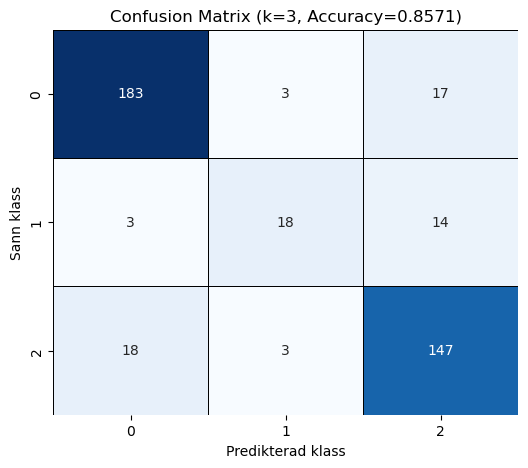

Resultat för k = 7: Accuracy: 0.8547


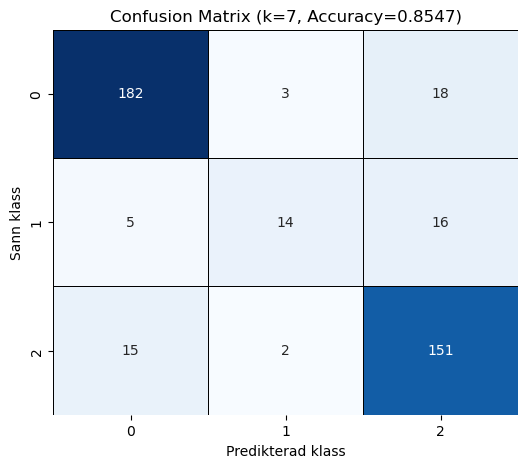

Resultat för k = 11: Accuracy: 0.8424


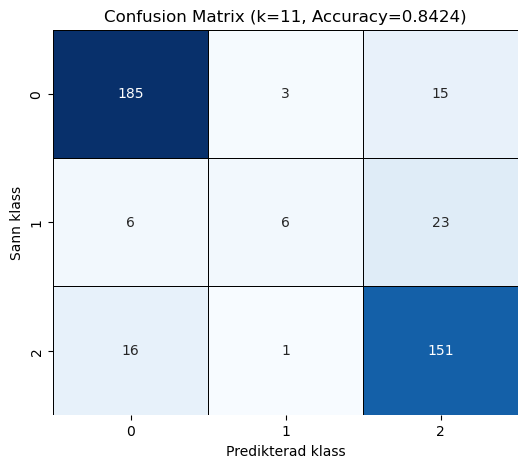

In [17]:
## ----------------------------------------------------------------------------------##
##                         --- DEL A: VARIATION AV K ---                             ##
## ----------------------------------------------------------------------------------##

print("===================================================================================")
print("                --- KÖRNING A: K-NN med varierande k (Split: 70/30) ---")
print("===================================================================================")

X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_raw, y, test_size=0.3, random_state=42
)

k_values = [3, 7, 11] 

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_k, y_train_k)
    y_pred = knn.predict(X_test_k)

    accuracy = accuracy_score(y_test_k, y_pred)
    conf_matrix = confusion_matrix(y_test_k, y_pred)

    print(f"Resultat för k = {k}: Accuracy: {accuracy:.4f}")
    plot_confusion_matrix(conf_matrix, title=f'Confusion Matrix (k={k}, Accuracy={accuracy:.4f})')


              --- KÖRNING B: Jämförelse Normalisering & Split (k=5) ---

--- Split: Train=90%, Test=10% (Icke-normaliserat) ---
Accuracy: 0.8309


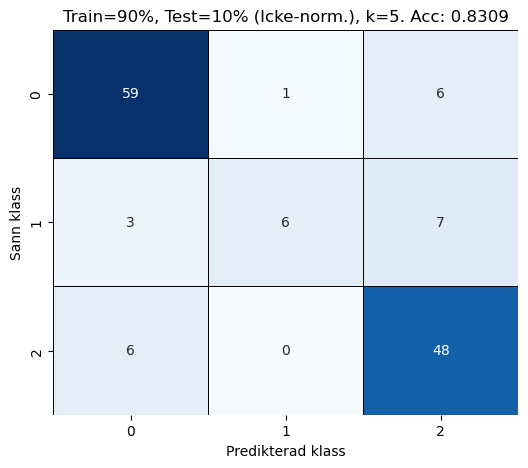


--- Split: Train=90%, Test=10% (Normaliserat [0,1]) ---
Accuracy: 0.8162


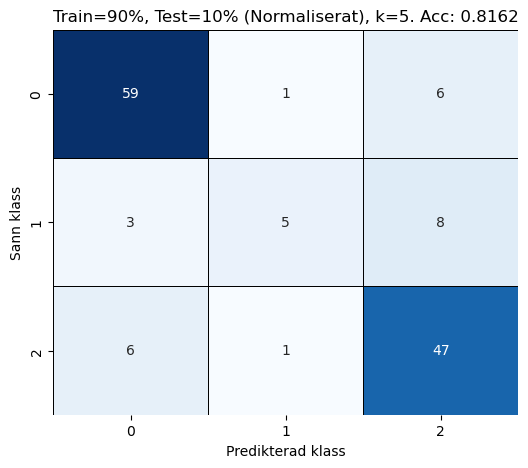


--- Split: Train=2/3, Test=1/3 (Icke-normaliserat) ---
Accuracy: 0.8581


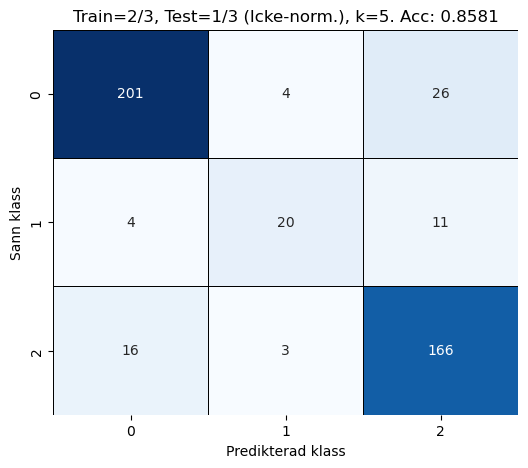


--- Split: Train=2/3, Test=1/3 (Normaliserat [0,1]) ---
Accuracy: 0.8492


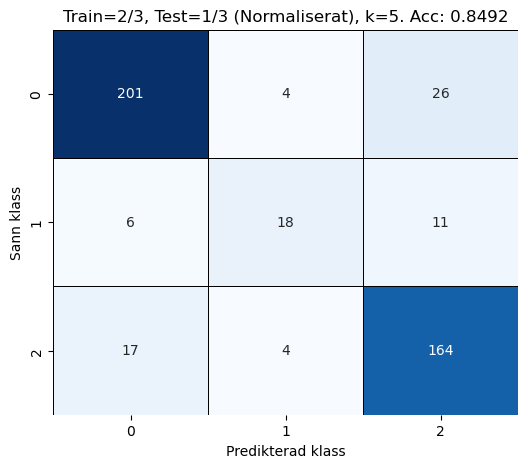


--- Split: Train=50%, Test=50% (Icke-normaliserat) ---
Accuracy: 0.8685


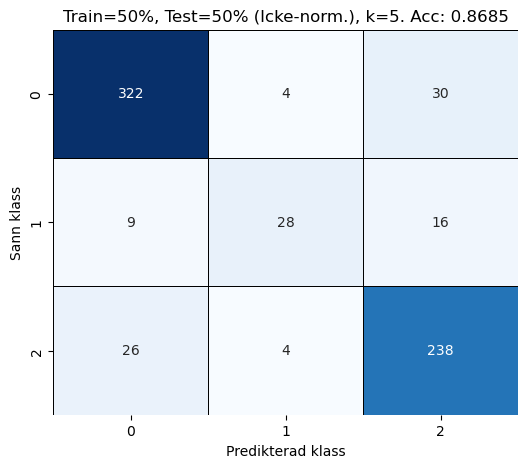


--- Split: Train=50%, Test=50% (Normaliserat [0,1]) ---
Accuracy: 0.8552


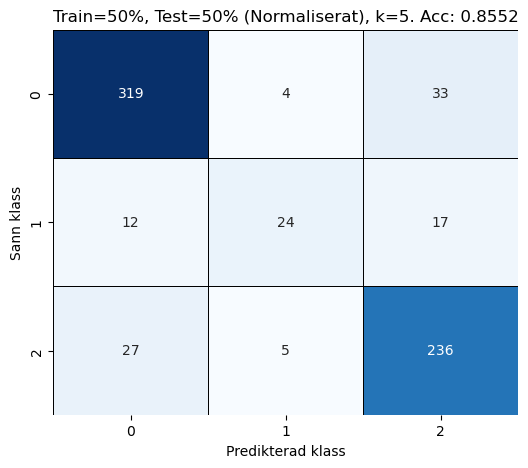

In [11]:
## ------------------------------------------------------------------------------------##
##                   --- DEL B: NORMALISERING OCH SPLIT-VARIATION ---                  ##
## ------------------------------------------------------------------------------------##

print("\n=====================================================================================")
print("              --- KÖRNING B: Jämförelse Normalisering & Split (k=5) ---")
print("=====================================================================================")

k_fixed = 5
splits = {
    "Train=90%, Test=10%": 0.1,
    "Train=2/3, Test=1/3": 1/3, 
    "Train=50%, Test=50%": 0.5
}

for split_name, test_size in splits.items():
    
    # --- 1. Icke-normaliserat data (Originaldata) ---
    X_train_raw_s, X_test_raw_s, y_train_s, y_test_s = train_test_split(
        X_raw, y, test_size=test_size, random_state=42
    )
    knn_raw = KNeighborsClassifier(n_neighbors=k_fixed)
    knn_raw.fit(X_train_raw_s, y_train_s)
    y_pred_raw = knn_raw.predict(X_test_raw_s)

    accuracy_raw = accuracy_score(y_test_s, y_pred_raw)
    conf_matrix_raw = confusion_matrix(y_test_s, y_pred_raw)

    print(f"\n--- Split: {split_name} (Icke-normaliserat) ---")
    print(f"Accuracy: {accuracy_raw:.4f}")
    plot_confusion_matrix(conf_matrix_raw, 
                          title=f'{split_name} (Icke-norm.), k={k_fixed}. Acc: {accuracy_raw:.4f}')


    # --- 2. Normaliserat data [0, 1] ---
    X_train_norm_s, X_test_norm_s, y_train_s, y_test_s = train_test_split(
        X_norm_df, y, test_size=test_size, random_state=42
    )
    knn_norm = KNeighborsClassifier(n_neighbors=k_fixed)
    knn_norm.fit(X_train_norm_s, y_train_s)
    y_pred_norm = knn_norm.predict(X_test_norm_s)

    accuracy_norm = accuracy_score(y_test_s, y_pred_norm)
    conf_matrix_norm = confusion_matrix(y_test_s, y_pred_norm)

    print(f"\n--- Split: {split_name} (Normaliserat [0,1]) ---")
    print(f"Accuracy: {accuracy_norm:.4f}")
    plot_confusion_matrix(conf_matrix_norm, 
                          title=f'{split_name} (Normaliserat), k={k_fixed}. Acc: {accuracy_norm:.4f}')

In [28]:
# Mappa alla variabler för looping
k_values = [3, 7, 11]
splits = {
    "Train=90%, Test=10%": 0.1,
    "Train=2/3, Test=1/3": 1/3, 
    "Train=50%, Test=50%": 0.5
}
data_sets = {
    "Icke-normaliserat": X_raw,
    "Normaliserat [0,1]": X_norm_df
}

run_results = []
körning_nr = 1

# --- KÖR ALLA 18 KOMBINATIONER OCH SAMLA RESULTAT ---

for split_name, test_size in splits.items():
    for norm_name, X_data in data_sets.items():
        
        # Dela data för den aktuella split och normaliseringsnivån
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=test_size, random_state=42
        )
        
        for k in k_values:
            # Träna k-NN-modellen
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            # Lägg till resultatet i listan
            run_results.append({
                'Körning': körning_nr,
                'Split': split_name,
                'Data': norm_name,
                'k': k,
                'Accuracy': accuracy
            })
            körning_nr += 1

# --- SKRIVER UT RESULTATET PÅ DET BÄSTA SÄTTET ---

print("======================================================================================")
print("                    --- SAMMANFATTNING: ALLA 18 KÖRNINGAR ---")
print("======================================================================================")

for run in run_results:
    # Använder formatering för att säkerställa jämn layout
    print(f"Körning {run['Körning']:02d} | Split: {run['Split']} | Data: {run['Data']:<20} | k={run['k']:02d} | Accuracy: {run['Accuracy']:.4f}")


                    --- SAMMANFATTNING: ALLA 18 KÖRNINGAR ---
Körning 01 | Split: Train=90%, Test=10% | Data: Icke-normaliserat    | k=03 | Accuracy: 0.8382
Körning 02 | Split: Train=90%, Test=10% | Data: Icke-normaliserat    | k=07 | Accuracy: 0.8309
Körning 03 | Split: Train=90%, Test=10% | Data: Icke-normaliserat    | k=11 | Accuracy: 0.8456
Körning 04 | Split: Train=90%, Test=10% | Data: Normaliserat [0,1]   | k=03 | Accuracy: 0.8309
Körning 05 | Split: Train=90%, Test=10% | Data: Normaliserat [0,1]   | k=07 | Accuracy: 0.8235
Körning 06 | Split: Train=90%, Test=10% | Data: Normaliserat [0,1]   | k=11 | Accuracy: 0.8309
Körning 07 | Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat    | k=03 | Accuracy: 0.8603
Körning 08 | Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat    | k=07 | Accuracy: 0.8647
Körning 09 | Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat    | k=11 | Accuracy: 0.8359
Körning 10 | Split: Train=2/3, Test=1/3 | Data: Normaliserat [0,1]   | k=03 | Accur

In [12]:
# Mappa data till dictionary för enkel looping
data_sets = {
    "Icke-normaliserat (Original)": X_raw,
    "Normaliserat [0,1]": X_norm_df
}

         --- START: TOTALT 18 KÖRNINGAR (3 K x 2 NORM. x 3 SPLITS) ---

[Körning 1/18] Split: Train=90%, Test=10% | Data: Icke-normaliserat (Original) | k: 3
Accuracy: 0.8382


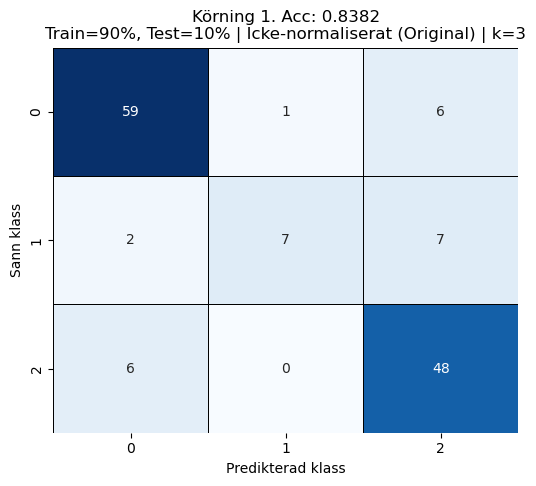


[Körning 2/18] Split: Train=90%, Test=10% | Data: Icke-normaliserat (Original) | k: 7
Accuracy: 0.8309


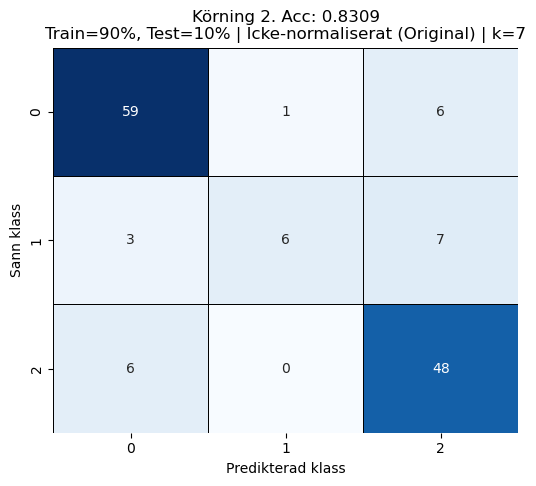


[Körning 3/18] Split: Train=90%, Test=10% | Data: Icke-normaliserat (Original) | k: 11
Accuracy: 0.8456


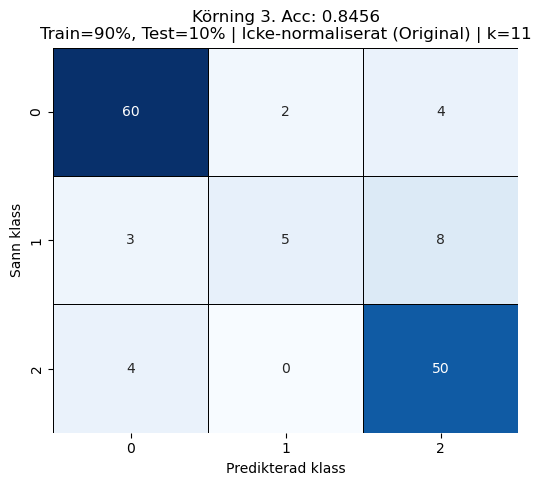


[Körning 4/18] Split: Train=90%, Test=10% | Data: Normaliserat [0,1] | k: 3
Accuracy: 0.8309


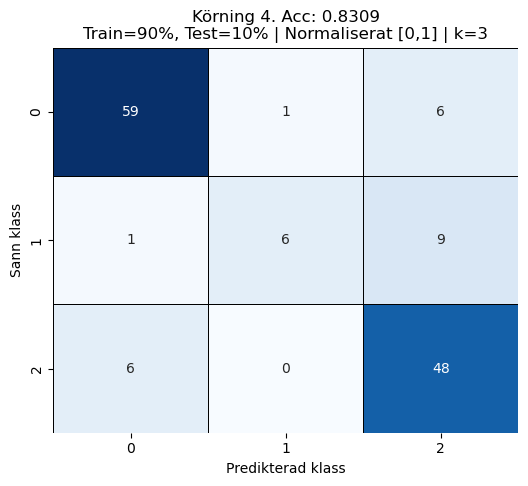


[Körning 5/18] Split: Train=90%, Test=10% | Data: Normaliserat [0,1] | k: 7
Accuracy: 0.8235


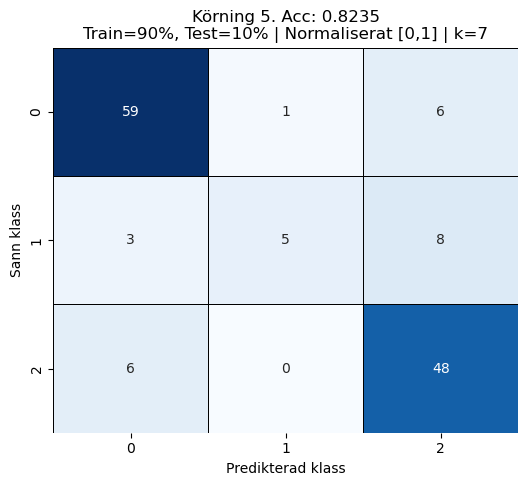


[Körning 6/18] Split: Train=90%, Test=10% | Data: Normaliserat [0,1] | k: 11
Accuracy: 0.8309


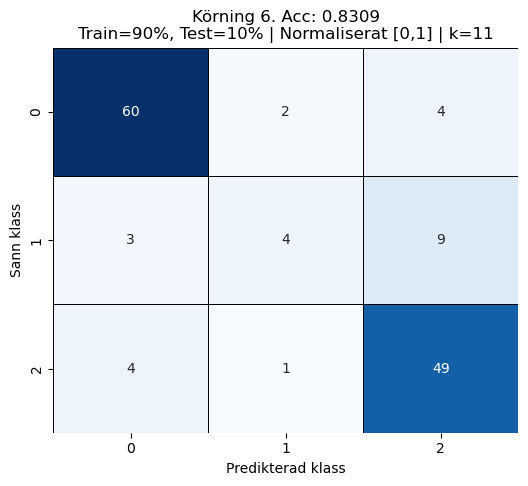


[Körning 7/18] Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat (Original) | k: 3
Accuracy: 0.8603


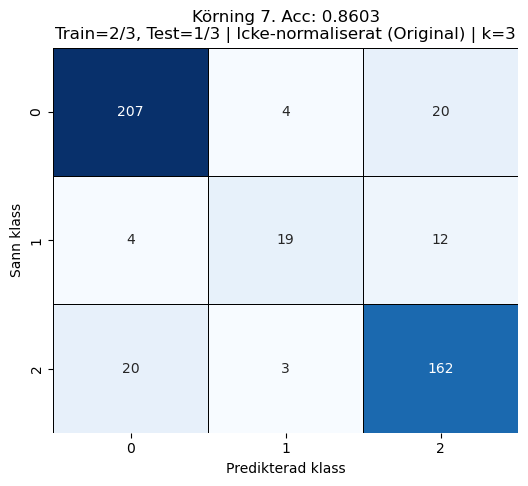


[Körning 8/18] Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat (Original) | k: 7
Accuracy: 0.8647


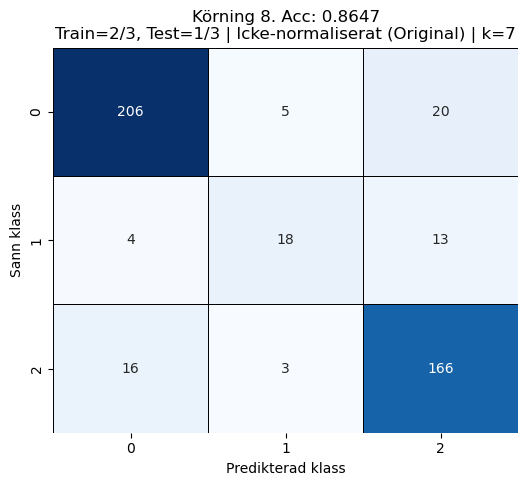


[Körning 9/18] Split: Train=2/3, Test=1/3 | Data: Icke-normaliserat (Original) | k: 11
Accuracy: 0.8359


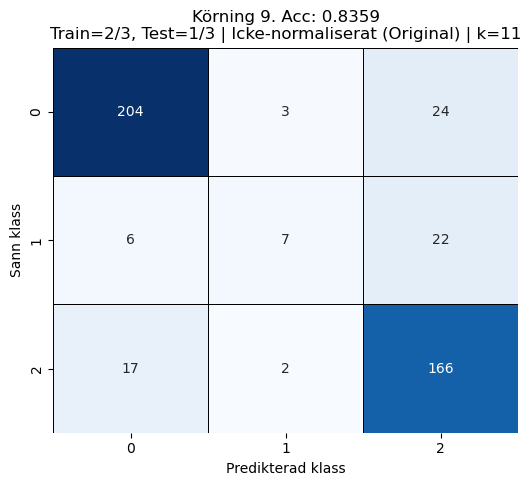


[Körning 10/18] Split: Train=2/3, Test=1/3 | Data: Normaliserat [0,1] | k: 3
Accuracy: 0.8603


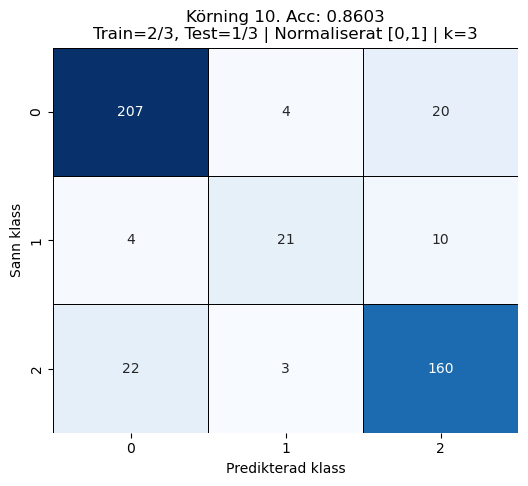


[Körning 11/18] Split: Train=2/3, Test=1/3 | Data: Normaliserat [0,1] | k: 7
Accuracy: 0.8514


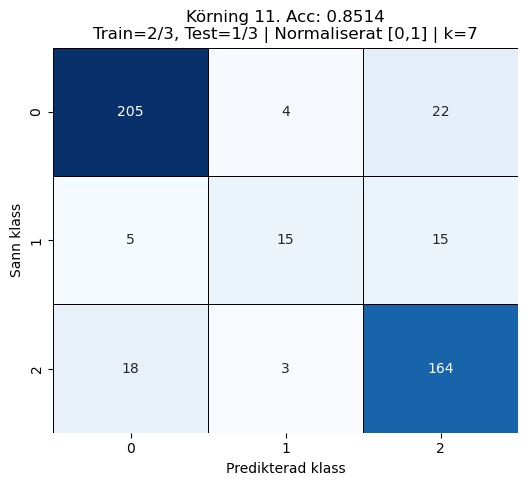


[Körning 12/18] Split: Train=2/3, Test=1/3 | Data: Normaliserat [0,1] | k: 11
Accuracy: 0.8315


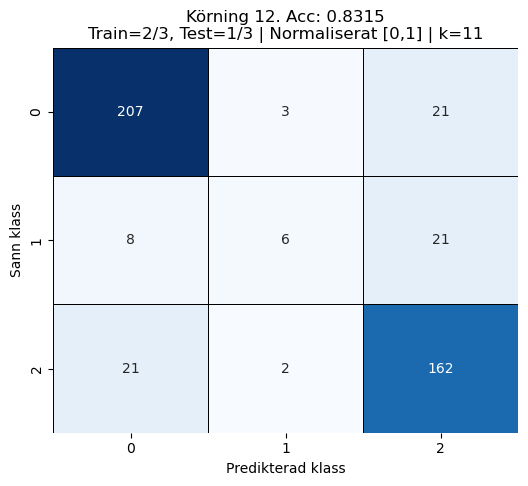


[Körning 13/18] Split: Train=50%, Test=50% | Data: Icke-normaliserat (Original) | k: 3
Accuracy: 0.8582


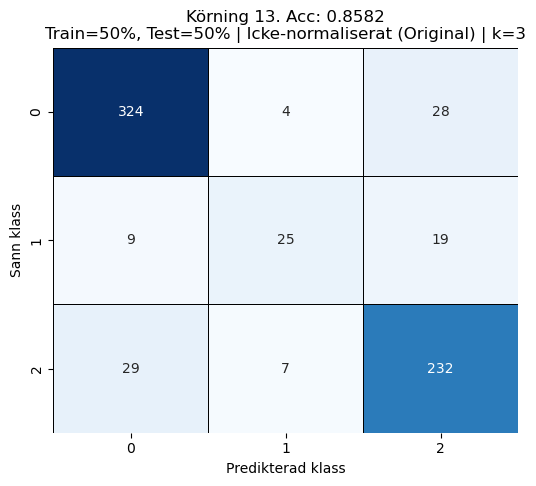


[Körning 14/18] Split: Train=50%, Test=50% | Data: Icke-normaliserat (Original) | k: 7
Accuracy: 0.8582


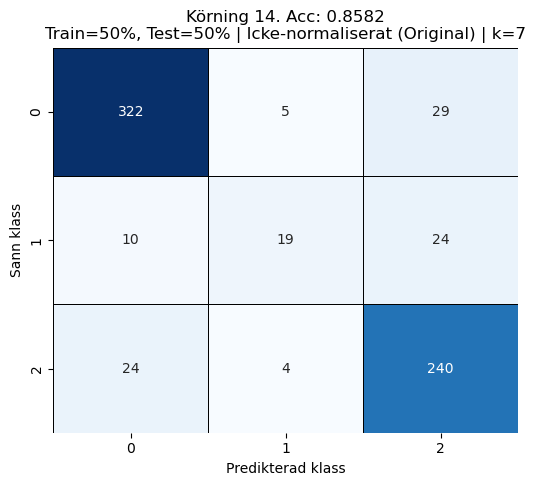


[Körning 15/18] Split: Train=50%, Test=50% | Data: Icke-normaliserat (Original) | k: 11
Accuracy: 0.8405


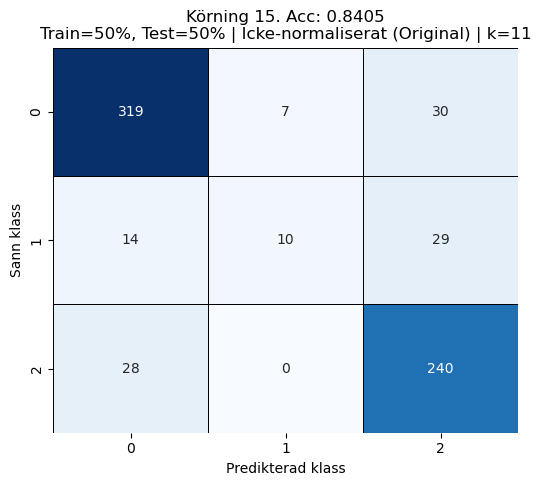


[Körning 16/18] Split: Train=50%, Test=50% | Data: Normaliserat [0,1] | k: 3
Accuracy: 0.8567


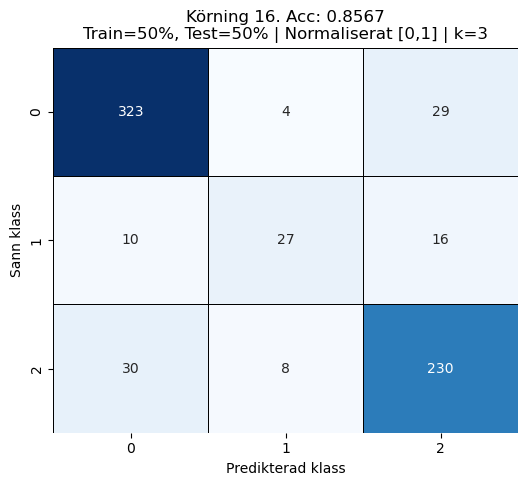


[Körning 17/18] Split: Train=50%, Test=50% | Data: Normaliserat [0,1] | k: 7
Accuracy: 0.8449


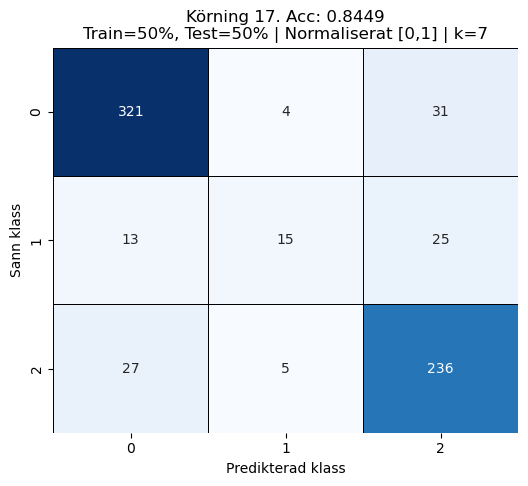


[Körning 18/18] Split: Train=50%, Test=50% | Data: Normaliserat [0,1] | k: 11
Accuracy: 0.8316


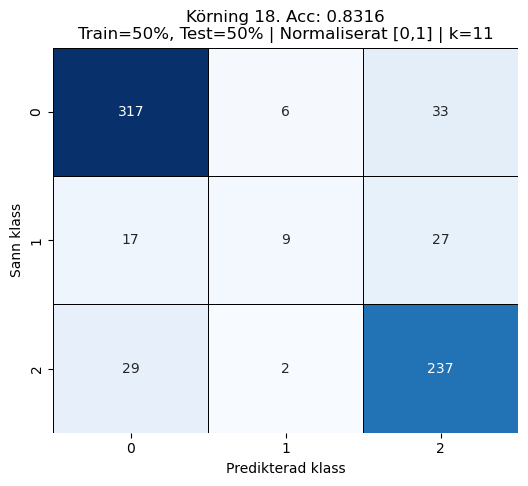


                           --- KLART! Alla 18 körningar är genomförda. ---


In [13]:
## -----------------------------------------------------------------------------------------##
##                           ---  KÖR ALLA 18 KOMBINATIONER ---                             ##
## -----------------------------------------------------------------------------------------##

print("===============================================================================")
print("         --- START: TOTALT 18 KÖRNINGAR (3 K x 2 NORM. x 3 SPLITS) ---")
print("===============================================================================")

k_values = [3, 7, 11]
splits = {
    "Train=90%, Test=10%": 0.1,
    "Train=2/3, Test=1/3": 1/3, 
    "Train=50%, Test=50%": 0.5
}
körning_nr = 1

for split_name, test_size in splits.items():
    for norm_name, X_data in data_sets.items():
        
        # Dela data för den aktuella split och normaliseringsnivån
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y, test_size=test_size, random_state=42
        )
        
        for k in k_values:
            # Träna k-NN-modellen
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            # Beräkna och presentera resultat
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)

            print(f"\n[Körning {körning_nr}/18] Split: {split_name} | Data: {norm_name} | k: {k}")
            print(f"Accuracy: {accuracy:.4f}")
            
            plot_confusion_matrix(
                conf_matrix, 
                title=f'Körning {körning_nr}. Acc: {accuracy:.4f}\n{split_name} | {norm_name} | k={k}'
            )
            
            körning_nr += 1

print("\n========================================================================================================")
print("                           --- KLART! Alla 18 körningar är genomförda. ---")
print("========================================================================================================")